# Exploring Trader Behavior vs Market Sentiment

**Goal:** Understand how trader performance metrics — such as profitability, trade volume, and activity patterns — vary with Bitcoin market sentiment (Fear vs Greed).  

**Data Sources:**
- `historical_data.csv` → Trader performance and transaction details  
- `fear_greed_index.csv` → Daily Bitcoin market sentiment (Fear or Greed classification)

All processed files, visualizations, and summaries are stored in the `ds_outputs/` and `csv_files/` folders.

---

**Notebook Sections:**

1. **Setup & Imports** – Initialize libraries, configure output directories, and set visualization themes.  
2. **Data Loading** – Import raw trader and sentiment datasets from local files.  
3. **Data Overview** – Inspect structure, missing values, and descriptive statistics for both datasets.  
4. **Data Cleaning & Preprocessing** – Handle duplicates, missing values, and outliers; standardize timestamps.  
5. **Market Sentiment Analysis** – Explore fear/greed frequency, streaks, and time-based sentiment trends.  
6. **Trader Behavior Analysis** – Examine PnL distribution, daily trade volume, buy/sell ratios, and correlations.  
7. **Merged Analysis** – Combine market sentiment with trader data to analyze performance under each sentiment.  
8. **Advanced Insights** – Visualize profit distribution by sentiment, detect anomalies, and study rolling averages.

---

This analysis bridges **trading behavior** and **market psychology**, providing insights into how emotion-driven sentiment impacts performance and risk-taking behavior.


### 🧩 Project Setup and Configuration

This section initializes the analysis environment by importing essential Python libraries, creating an output directory, and setting default visualization preferences for consistent and professional-looking plots.

**Code Label:** *Code 1 – Environment Setup and Plot Configuration*

**Key Details:**
- **pandas**, **numpy** → Data manipulation and computation  
- **matplotlib**, **seaborn** → Data visualization  
- **pathlib** → Simplifies file path management  
- Creates a dedicated output folder: **`ds_outputs`** for saving results and figures  
- Applies a consistent plotting style: **whitegrid** with large, readable text (`context='talk'`)


In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# outputs directory
OUT_DIR = Path("ds_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

sns.set(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (12,6)

print("Output directory:", OUT_DIR)

Output directory: ds_outputs


### 📂 Data Import: Loading Historical Trading and Sentiment Datasets

This section loads the raw datasets into memory from local file paths for further processing and analysis.

**Code Label:** *Code 2 – Data Loading and Verification*

**Key Details:**
- Reads two primary CSV files:
  - **`historical_data.csv`** → Contains trader activity and performance data  
  - **`fear_greed_index.csv`** → Contains daily market sentiment values  
- Uses `pandas.read_csv()` to load both datasets into DataFrames  
- Displays shape (rows × columns) to confirm successful loading and understand dataset size
- Ensures both datasets are accessible in memory for subsequent cleaning and merging steps


In [56]:
hist_path = "/content/sample_data/historical_data.csv"
fg_path = "/content/sample_data/fear_greed_index.csv"

trades_raw = pd.read_csv(hist_path)
fg_raw = pd.read_csv(fg_path)

print("✅ Data loaded successfully!")
print("Trades data shape:", trades_raw.shape)
print("Fear-Greed data shape:", fg_raw.shape)


✅ Data loaded successfully!
Trades data shape: (211224, 16)
Fear-Greed data shape: (2644, 4)


### 🔍 Data Quality Check: Exploring Missing and Empty Columns

This section performs an initial data audit to understand the quality and completeness of the **trader dataset**.

**Code Label:** *Code 3 – Data Profiling and Missing Value Inspection*

**Key Steps:**
- Prints the overall dataset shape (rows × columns).  
- Counts **total missing values** across all columns to assess data cleanliness.  
- Identifies:
  - **Fully empty columns** → columns containing only null values.  
  - **Partially filled columns** → columns that have at least some valid data.  
- Displays the first 5 rows from columns that contain data to get a quick preview of usable features.

**Purpose:**  
Ensures awareness of missing or irrelevant fields early in the pipeline before data cleaning and feature extraction.


In [57]:
print("Shape:", trades_raw.shape)
print("\nTotal missing values:", trades_raw.isnull().sum().sum())

empty_cols = [col for col in trades_raw.columns if trades_raw[col].isnull().all()]
print(f"\nFully empty columns ({len(empty_cols)}):", empty_cols[:10], "...")

partial_cols = [col for col in trades_raw.columns if not trades_raw[col].isnull().all()]
print(f"\nColumns with data ({len(partial_cols)}):", partial_cols[:10])

display(trades_raw[partial_cols].head())


Shape: (211224, 16)

Total missing values: 0

Fully empty columns (0): [] ...

Columns with data (16): ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## 📊 Step 1: Basic Dataset Overview and Preliminary Exploration

**Code Label:** *Code 4 – Dataset Overview, Null Check, and Initial Visualizations*

### 🎯 Objective:
To perform an initial structural and descriptive analysis of both the **Trader Data** and the **Fear-Greed Index Data** before proceeding with deeper analytics.

---

### 🔹 Trader Data Overview
- Displays column types, non-null counts, and memory usage using `info()`.
- Shows a sample of the first 5 rows for a quick visual inspection.
- Generates **numeric** and **categorical** summary statistics separately using `describe()`.

---

### 🔹 Fear-Greed Data Overview
- Prints metadata (`info()`) and sample rows (`head()`).
- Displays **numeric** and **categorical** summaries for understanding data ranges and sentiment labels.

---

### 🔹 Missing Value Analysis
- Counts missing values for each column in both datasets.
- Helps identify incomplete or low-quality features that need cleaning in subsequent steps.

---

### 🔹 Timestamp Processing
- Converts the `'Timestamp IST'` column into a **datetime** object.
- Extracts the **date** component to align time-based comparisons between trader activity and sentiment data.

---

### 📈 Visualizations
1. **Daily Trade Count Histogram**  
   - Displays how many trades occurred each day.  
   - Helps detect data collection gaps or unusually active trading periods.

2. **Daily Total USD Volume Trend**  
   - Plots the total trading volume (in USD) per day using a line chart.  
   - Useful for identifying high-liquidity periods and trading spikes.

---

### 💾 Outputs Generated:
- `outputs/daily_trade_counts.png` → Daily number of trades bar chart  
- `outputs/daily_volume_trend.png` → Daily total USD trading volume trend

**Purpose:**  
These steps provide an at-a-glance understanding of data coverage, quality, and temporal activity patterns, setting the stage for deeper quantitative analysis.


=== TRADER DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  floa

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



=== NUMERIC SUMMARY STATISTICS (trades) ===


,count,mean,std,min,25%,50%,75%,max
Execution Price,211224.0,1.141472e+04,2.944765e+04,4.530000e-06,4.854700e+00,1.828000e+01,1.015800e+02,1.090040e+05
Size Tokens,211224.0,4.623365e+03,1.042729e+05,8.740000e-07,2.940000e+00,3.200000e+01,1.879025e+02,1.582244e+07
Size USD,211224.0,5.639451e+03,3.657514e+04,0.000000e+00,1.937900e+02,5.970450e+02,2.058960e+03,3.921431e+06
Start Position,211224.0,-2.994625e+04,6.738074e+05,-1.433463e+07,-3.762311e+02,8.472793e+01,9.337278e+03,3.050948e+07
Closed PnL,211224.0,4.874900e+01,9.191648e+02,-1.179901e+05,0.000000e+00,0.000000e+00,5.792797e+00,1.353291e+05
Order ID,211224.0,6.965388e+10,1.835753e+10,1.732711e+08,5.983853e+10,7.442939e+10,8.335543e+10,9.014923e+10
Fee,211224.0,1.163967e+00,6.758854e+00,-1.175712e+00,1.612094e-02,8.957750e-02,3.938110e-01,8.374716e+02
Trade ID,211224.0,5.628549e+14,3.257565e+14,0.000000e+00,2.810000e+14,5.620000e+14,8.460000e+14,1.130000e+15
Timestamp,211224.0,1.737744e+12,8.689920e+09,1.680000e+12,1.740000e+12,1.740000e+12,1.740000e+12,1.750000e+12



=== CATEGORICAL SUMMARY STATISTICS (trades) ===


,count,unique,top,freq
Account,211224,32,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,40184
Coin,211224,246,HYPE,68005
Side,211224,2,SELL,108528
Timestamp IST,211224,27977,14-02-2025 00:31,441
Direction,211224,12,Open Long,49895
Transaction Hash,211224,101184,0x00000000000000000000000000000000000000000000...,9032



=== FEAR/GREED DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

Sample rows (fear_greed):


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



=== NUMERIC SUMMARY STATISTICS (fear_greed) ===


,count,mean,std,min,25%,50%,75%,max
timestamp,2644.0,1.631899e+09,6.597967e+07,1.517463e+09,1.574811e+09,1.631900e+09,1.688989e+09,1.746164e+09
value,2644.0,4.698109e+01,2.182768e+01,5.000000e+00,2.800000e+01,4.600000e+01,6.600000e+01,9.500000e+01



=== CATEGORICAL SUMMARY STATISTICS (fear_greed) ===


,count,unique,top,freq
classification,2644,5,Fear,781
date,2644,2644,2025-05-02,1



Missing values (trader data):


,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0



Missing values (fear/greed data):


,0
timestamp,0
value,0
classification,0
date,0


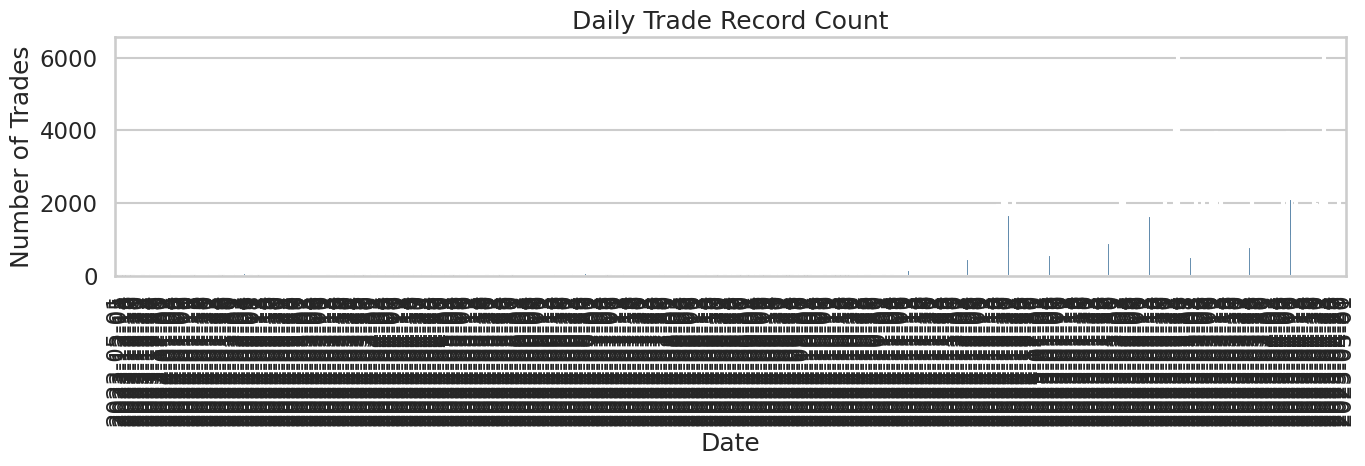

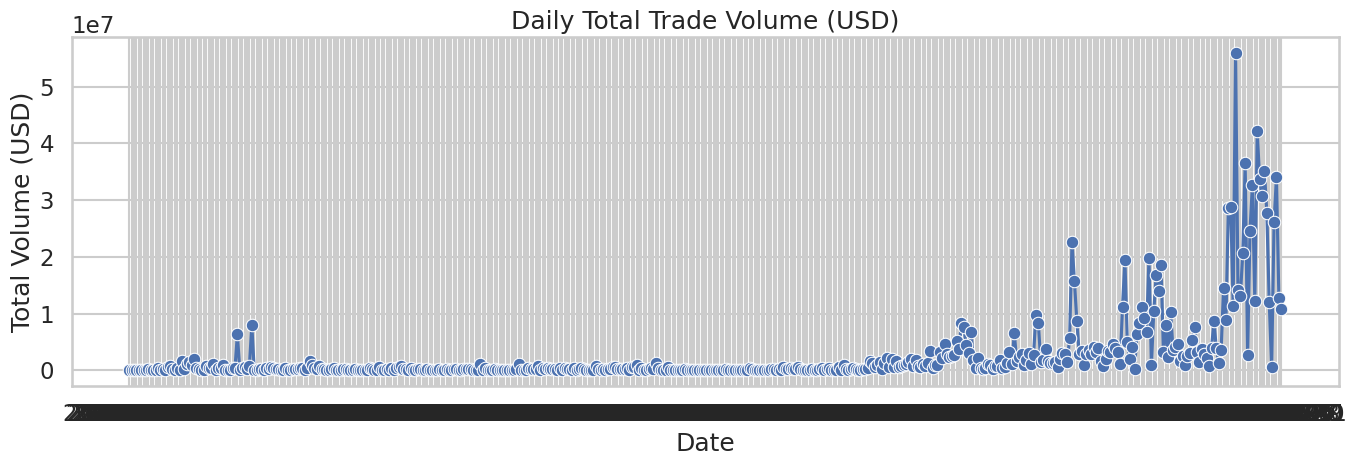

In [58]:
print("=== TRADER DATA OVERVIEW ===")
trades_raw.info()

print("\nSample rows (trades):")
display(trades_raw.head(5))

print("\n=== NUMERIC SUMMARY STATISTICS (trades) ===")
display(trades_raw.describe().T)

print("\n=== CATEGORICAL SUMMARY STATISTICS (trades) ===")
display(trades_raw.describe(include=['object', 'category']).T)

print("\n=== FEAR/GREED DATA OVERVIEW ===")
fg_raw.info()

print("\nSample rows (fear_greed):")
display(fg_raw.head(5))

print("\n=== NUMERIC SUMMARY STATISTICS (fear_greed) ===")
display(fg_raw.describe().T)

print("\n=== CATEGORICAL SUMMARY STATISTICS (fear_greed) ===")
display(fg_raw.describe(include=['object', 'category']).T)

print("\nMissing values (trader data):")
display(trades_raw.isnull().sum().sort_values(ascending=False))

print("\nMissing values (fear/greed data):")
display(fg_raw.isnull().sum().sort_values(ascending=False))

trades_raw['Timestamp IST'] = pd.to_datetime(trades_raw['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trades_raw['Date'] = trades_raw['Timestamp IST'].dt.date

daily_counts = trades_raw.groupby('Date').size()
plt.figure(figsize=(14,5))
sns.barplot(x=daily_counts.index.astype(str), y=daily_counts.values, color='steelblue')
plt.xticks(rotation=90)
plt.title("Daily Trade Record Count")
plt.xlabel("Date")
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.savefig("outputs/daily_trade_counts.png")
plt.show()

daily_volume = trades_raw.groupby('Date')['Size USD'].sum()
plt.figure(figsize=(14,5))
sns.lineplot(x=daily_volume.index.astype(str), y=daily_volume.values, marker='o')
plt.title("Daily Total Trade Volume (USD)")
plt.xlabel("Date")
plt.ylabel("Total Volume (USD)")
plt.tight_layout()
plt.savefig("outputs/daily_volume_trend.png")
plt.show()

In [59]:
print(fg_raw.columns)


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


## 🧹 Step 2: Data Cleaning and Pre-Processing  

**Code Label:** *Code 5 – Data Cleaning and Preprocessing Pipeline*

---

### 🎯 Objective:
To ensure both datasets (Trader Data and Sentiment Data) are accurate, consistent, and ready for analysis by removing duplicates, handling missing values, and eliminating outliers.

---

### 🔹 Trader Data Cleaning Process

1. **Timestamp Conversion**  
   - Converted `'Timestamp IST'` into a proper `datetime` format.  
   - Extracted only the **date** portion to support merging with the sentiment dataset.

2. **Duplicate Removal**  
   - Checked for and removed duplicate trading records to prevent double-counting.

3. **Handling Missing Values**  
   - Replaced missing numeric fields (`Closed PnL`, `Size USD`, `Execution Price`, `Fee`) with zero for consistency.

4. **Outlier Removal (Closed PnL)**  
   - Used **Z-score method (3σ rule)** to identify and remove extreme profit/loss values that could distort averages.  
   - Outliers beyond ±3 standard deviations from the mean were excluded.

---

### 🔹 Sentiment Data Cleaning Process

1. **Date Standardization**  
   - Converted `'date'` column to a proper `datetime` object.  
   - Extracted only the **date** portion for consistent alignment with trading data.

2. **Duplicate Removal**  
   - Removed repeated rows to keep one record per day.

3. **Missing Value Imputation**  
   - Applied **forward fill** (propagating last valid entry) and **backward fill** (using next valid entry) for smooth continuity.

---

### 💾 Outputs:
Cleaned and standardized datasets are saved for downstream analysis:

| Dataset | File Path | Description |
|----------|------------|-------------|
| **Trader Data** | `csv_files/cleaned_trader_data.csv` | Outlier-free, deduplicated trader activity data |
| **Sentiment Data** | `csv_files/cleaned_sentiment.csv` | Continuous daily sentiment index data |

---

### ✅ Key Benefits:
- Removes noise and inconsistencies from raw inputs.  
- Aligns both datasets chronologically for meaningful time-based merging.  
- Prevents statistical distortion in subsequent visualizations and metrics.


In [60]:
print("=== STARTING DATA CLEANING ===")

trades = trades_raw.copy()

trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trades['Date'] = trades['Timestamp IST'].dt.date

initial_len = len(trades)
trades.drop_duplicates(inplace=True)
print(f"Removed {initial_len - len(trades)} duplicate rows from trader data")

trades.fillna({
    'Closed PnL': 0,
    'Size USD': 0,
    'Execution Price': 0,
    'Fee': 0
}, inplace=True)

z_scores = np.abs((trades['Closed PnL'] - trades['Closed PnL'].mean()) / trades['Closed PnL'].std())
trades = trades[z_scores < 3]
print(f"Removed {(initial_len - len(trades))} outlier rows based on Closed PnL")

fg = fg_raw.copy()

fg['date'] = pd.to_datetime(fg['date'], errors='coerce')
fg['Date'] = fg['date'].dt.date

initial_fg_len = len(fg)
fg.drop_duplicates(inplace=True)
print(f"Removed {initial_fg_len - len(fg)} duplicate rows from sentiment data")

fg.ffill(inplace=True)
fg.bfill(inplace=True)

os.makedirs("csv_files", exist_ok=True)

trades.to_csv("csv_files/cleaned_trader_data.csv", index=False)
fg.to_csv("csv_files/cleaned_sentiment.csv", index=False)

print("\n✅ CLEANING COMPLETE")
print(f"Cleaned trader dataset saved → csv_files/cleaned_trader_data.csv  | Shape: {trades.shape}")
print(f"Cleaned sentiment dataset saved → csv_files/cleaned_sentiment.csv | Shape: {fg.shape}")


=== STARTING DATA CLEANING ===
Removed 0 duplicate rows from trader data
Removed 854 outlier rows based on Closed PnL
Removed 0 duplicate rows from sentiment data

✅ CLEANING COMPLETE
Cleaned trader dataset saved → csv_files/cleaned_trader_data.csv  | Shape: (210370, 17)
Cleaned sentiment dataset saved → csv_files/cleaned_sentiment.csv | Shape: (2644, 5)


## 💡 Step 3: Market Sentiment Analysis  

**Code Label:** *Code 6 – Fear vs. Greed Sentiment Analysis*

---

### 🎯 Objective:
To explore and visualize overall market mood by analyzing the balance between **Fear** and **Greed** in the market sentiment dataset.

---

### 🔹 Key Analysis Steps

1. **Sentiment Distribution**
   - Calculated total counts and percentages of “Fear” and “Greed” classifications.
   - Helps quantify how frequently each mood dominated the market.

2. **Sentiment Streaks**
   - Computed **consecutive streaks** (continuous runs) of “Fear” or “Greed” days using a cumulative group counter.
   - Identifies long-lasting sentiment phases or sudden shifts.

3. **Numerical Encoding**
   - Encoded categorical sentiment into numeric values for correlation and time-series analysis:
     - `Fear = 0`
     - `Greed = 1`

---

### 📊 Visualizations

#### 🥧 1. Market Sentiment Distribution
A **pie chart** showing the overall percentage share of Fear vs. Greed days.

#### 📈 2. Frequency of Sentiments
A **bar chart** comparing the number of days under each sentiment category.

#### 🕒 3. Sentiment Timeline
A **time series plot** mapping daily sentiment changes over time  
to observe **transitions**, **patterns**, and **market mood cycles**.

---

### ✅ Insights:
- Reveals the dominant market mood over the dataset period.  
- Highlights how long traders stayed in “Fear” or “Greed” phases.  
- Provides groundwork for connecting market mood to trader performance.

---

### ⚙️ Output:
All three plots are displayed directly in the notebook for instant visualization.


=== STARTING MARKET SENTIMENT ANALYSIS ===

Sentiment Counts:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Sentiment Percentage (%):
classification
Fear             29.54
Greed            23.94
Extreme Fear     19.21
Neutral          14.98
Extreme Greed    12.33
Name: count, dtype: float64

Top 5 Sentiment Streaks:
    classification  streak_group  streak_length
102  Extreme Greed           234             77
76    Extreme Fear           383             74
41    Extreme Fear           186             49
279           Fear           402             48
408          Greed           456             42


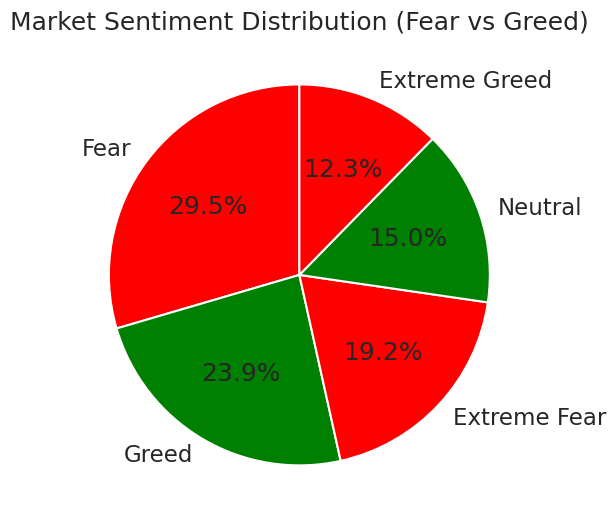

/tmp/ipython-input-3278890548.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'green'])
/tmp/ipython-input-3278890548.py:27: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'green'])


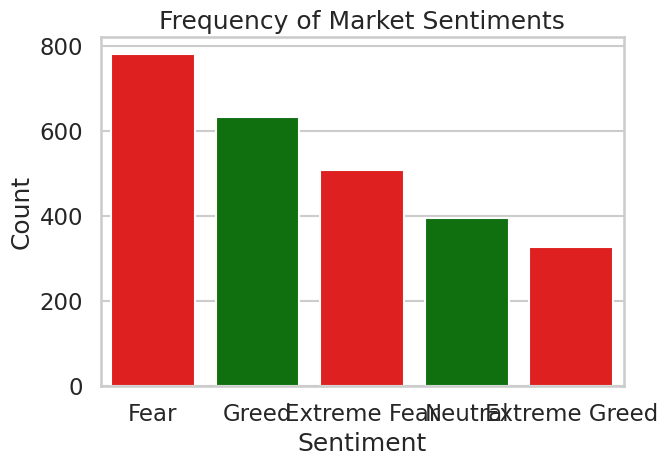

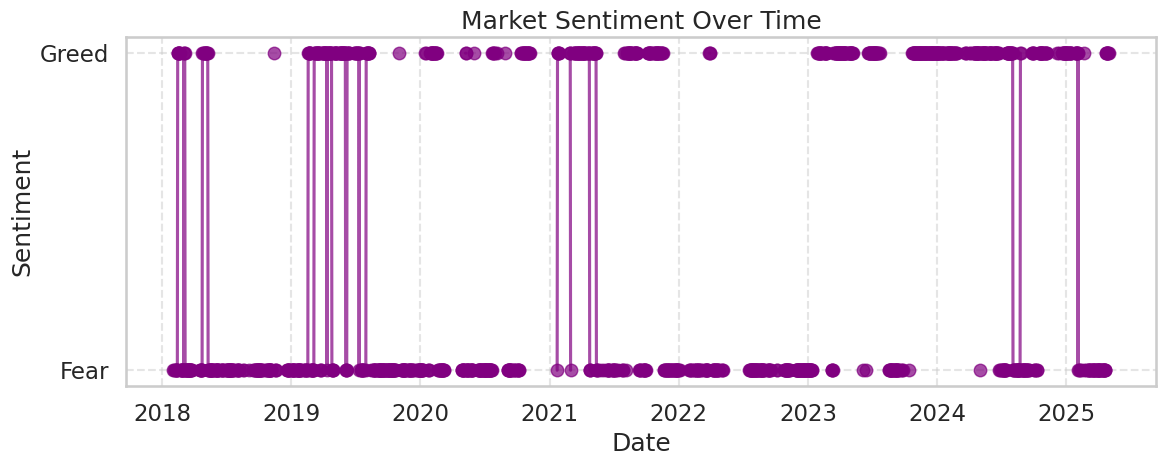


✅ Sentiment analysis completed and all plots displayed successfully.


In [61]:
print("=== STARTING MARKET SENTIMENT ANALYSIS ===")

sentiment_counts = fg['classification'].value_counts()
sentiment_percent = (sentiment_counts / len(fg)) * 100

print("\nSentiment Counts:")
print(sentiment_counts)
print("\nSentiment Percentage (%):")
print(sentiment_percent.round(2))

fg = fg.sort_values('date').reset_index(drop=True)
fg['streak_group'] = (fg['classification'] != fg['classification'].shift()).cumsum()
streaks = fg.groupby(['classification', 'streak_group']).size().reset_index(name='streak_length')

print("\nTop 5 Sentiment Streaks:")
print(streaks.sort_values('streak_length', ascending=False).head())

fg['sentiment_encoded'] = fg['classification'].map({'Fear': 0, 'Greed': 1})

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Market Sentiment Distribution (Fear vs Greed)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'green'])
plt.title('Frequency of Market Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(fg['date'], fg['sentiment_encoded'], marker='o', linestyle='-', color='purple', alpha=0.7)
plt.yticks([0, 1], ['Fear', 'Greed'])
plt.title('Market Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\n✅ Sentiment analysis completed and all plots displayed successfully.")


## 📊 Step 4: Trader Behavior Analysis  

**Code Label:** *Code 7 – Quantitative & Visual Analysis of Trader Activity*

---

### 🎯 Objective:
To measure and visualize how traders behaved over time through **profitability, trading volume, execution trends, and correlations** among financial indicators.

---

### 🔹 Key Metrics Computed (Per Day)

| Metric | Description |
|:--|:--|
| **Average Closed PnL** | Mean profit or loss across all trades per day |
| **Median Closed PnL** | Central tendency of profitability (less affected by outliers) |
| **Total Volume (USD)** | Total trade value in USD executed on a given day |
| **Average Execution Price** | Average transaction price of traded assets |
| **Trade Count** | Total number of trades executed per day |
| **Buy vs Sell Ratio** | Comparison of buyer vs seller activity trends |

---

### 🧮 Analytical Steps

1. **Data Preparation**  
   - Converted timestamps to valid `datetime` format.  
   - Grouped daily metrics and derived per-day trading behavior summaries.  

2. **Buy–Sell Activity Analysis**  
   - Counted daily “BUY” and “SELL” trades using pivot-style aggregation.

3. **Correlation Study**  
   - Evaluated interdependencies among financial variables:  
     *Closed PnL, Fee, Size USD,* and *Execution Price*.

---

### 📈 Visualizations

#### 1️⃣ Histogram – Closed PnL Distribution  
Shows profit/loss spread and skewness to assess volatility.

#### 2️⃣ Line Plot – Daily Average Closed PnL  
Depicts daily profitability trends to detect performance fluctuations.

#### 3️⃣ Line Plot – Daily Median Closed PnL  
Highlights robust central trend ignoring extreme outliers.

#### 4️⃣ Line Plot – Daily Total Trade Volume (USD)  
Shows how total transaction value varied over time.

#### 5️⃣ Comparison Plot – Buy vs Sell Trades  
Visualizes the trading momentum between buyers and sellers.

#### 6️⃣ Correlation Heatmap  
Displays linear relationships among major quantitative trading indicators.

---

### ✅ Insights:
- Identifies whether traders were consistently profitable or volatile.  
- Highlights trading days with extreme PnL or unusually high volumes.  
- Reveals how leverage, trade size, and prices relate to PnL outcomes.  

---

### ⚙️ Output:
All visualizations are directly displayed in the notebook for review and analysis.


=== STARTING TRADER BEHAVIOR ANALYSIS ===


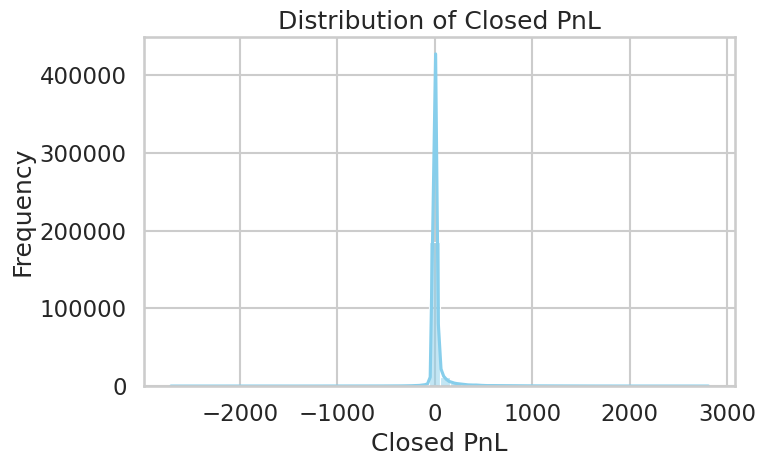

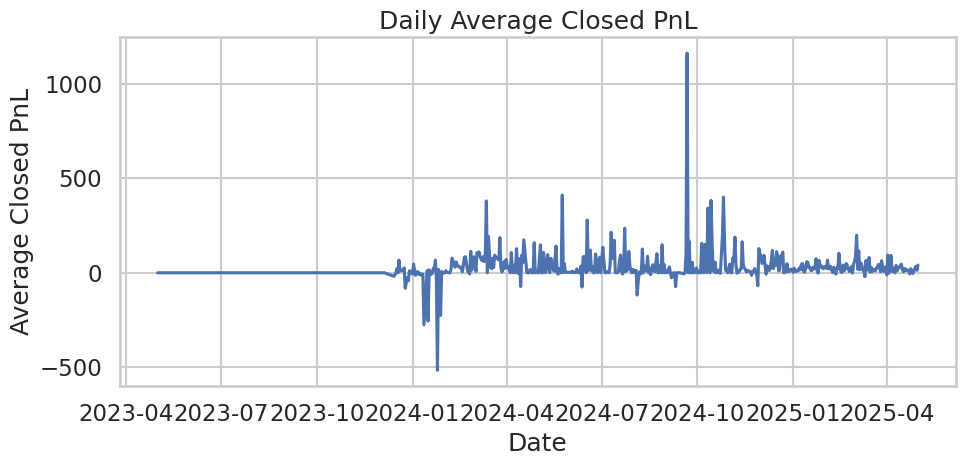

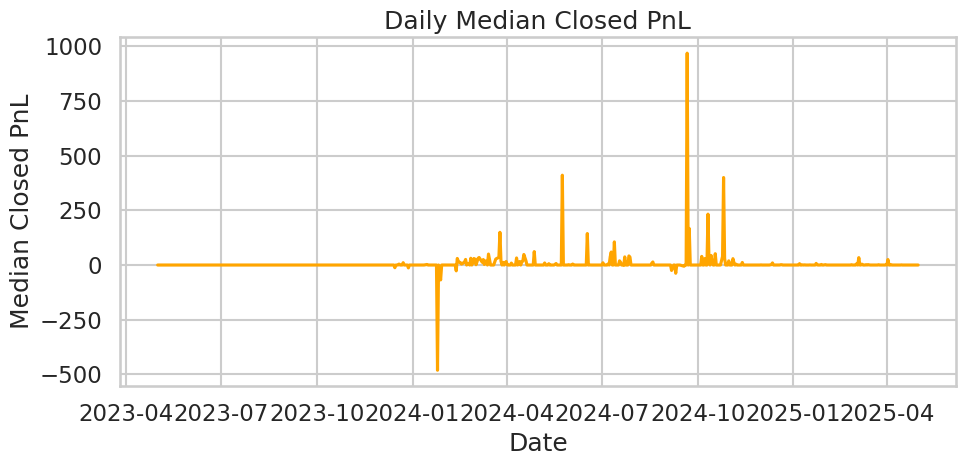

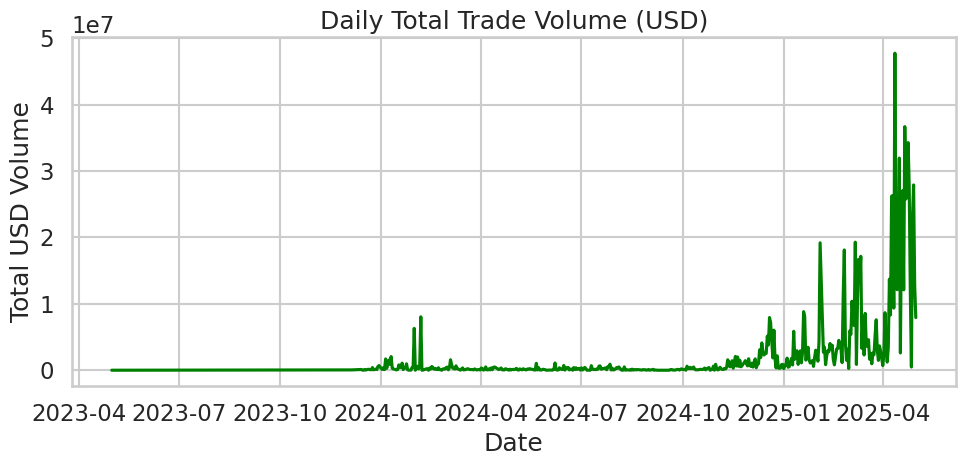

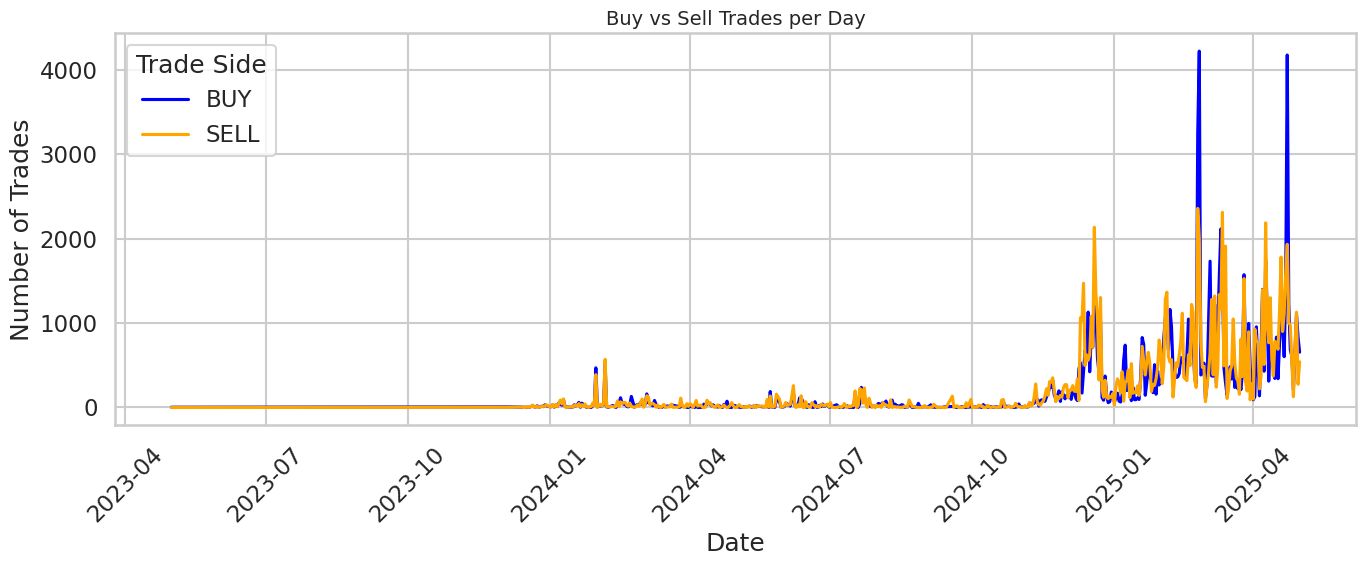

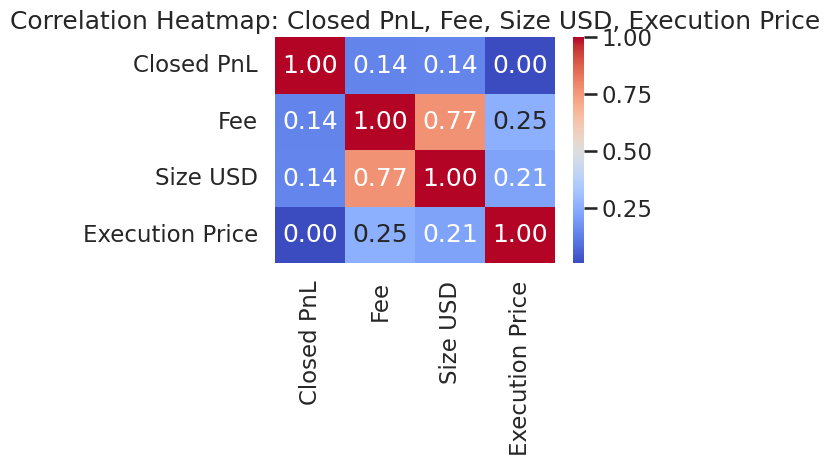


=== TRADER BEHAVIOR ANALYSIS COMPLETE ===


In [62]:
print("=== STARTING TRADER BEHAVIOR ANALYSIS ===")

df = trades.copy()

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

daily_stats = df.groupby('Date').agg({
    'Closed PnL': ['mean', 'median'],
    'Size USD': 'sum',
    'Execution Price': 'mean',
    'Account': 'count'
}).reset_index()

daily_stats.columns = ['Date', 'Avg Closed PnL', 'Median Closed PnL',
                       'Total Volume (USD)', 'Avg Execution Price', 'Trade Count']

buy_sell = df.groupby(['Date', 'Side']).size().unstack(fill_value=0)

corr_cols = ['Closed PnL', 'Fee', 'Size USD', 'Execution Price']
corr = df[corr_cols].corr()

plt.figure(figsize=(8, 5))
sns.histplot(df['Closed PnL'], bins=50, color='skyblue', kde=True)
plt.title("Distribution of Closed PnL")
plt.xlabel("Closed PnL")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_stats, x='Date', y='Avg Closed PnL')
plt.title("Daily Average Closed PnL")
plt.xlabel("Date")
plt.ylabel("Average Closed PnL")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_stats, x='Date', y='Median Closed PnL', color='orange')
plt.title("Daily Median Closed PnL")
plt.xlabel("Date")
plt.ylabel("Median Closed PnL")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_stats, x='Date', y='Total Volume (USD)', color='green')
plt.title("Daily Total Trade Volume (USD)")
plt.xlabel("Date")
plt.ylabel("Total USD Volume")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(data=buy_sell.reset_index(), x='Date', y='BUY', label='BUY', color='blue')
sns.lineplot(data=buy_sell.reset_index(), x='Date', y='SELL', label='SELL', color='orange')
plt.title("Buy vs Sell Trades per Day", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Trades")
plt.legend(title="Trade Side")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Closed PnL, Fee, Size USD, Execution Price")
plt.tight_layout()
plt.show()

print("\n=== TRADER BEHAVIOR ANALYSIS COMPLETE ===")


In [63]:
print("Trader Columns:", trader.columns.tolist())
print("Sentiment Columns:", sentiment.columns.tolist())


Trader Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'Date']
Sentiment Columns: ['timestamp', 'value', 'classification', 'date', 'Date']


## 🧩 Step 5 — Merge Market Sentiment and Trader Data
- Convert date columns to datetime format  
- Merge trader dataset with sentiment data on the `Date` field  
- Clean numeric columns for consistency  
- Aggregate and compare trader performance metrics (PnL, Fee, Volume) under Fear vs Greed  
- Visualize key relationships and correlations  


=== STARTING MERGE OF MARKET SENTIMENT AND TRADER DATA ===
Merged DataFrame shape: (210368, 22)
Merged Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'Date_x', 'timestamp', 'value', 'classification', 'date', 'Date_y']

=== Aggregated Trader Behavior by Market Sentiment ===


,Sentiment,Avg_PnL,Median_PnL,Avg_Fee,Total_Volume,Trade_Count
0,Extreme Fear,15.144921,0.0,1.040201,1.059314e+08,21303
1,Extreme Greed,38.404961,0.0,0.653786,1.197032e+08,39817
2,Fear,31.603244,0.0,1.398655,4.348119e+08,61587
3,Greed,25.905170,0.0,1.186013,2.665708e+08,50084
4,Neutral,25.114993,0.0,0.961250,1.614700e+08,37577


/tmp/ipython-input-2366248088.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Avg_PnL', data=agg_df, palette='Blues_d')
/tmp/ipython-input-2366248088.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Avg_Fee', data=agg_df, palette='Greens_d')
/tmp/ipython-input-2366248088.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Total_Volume', data=agg_df, palette='Purples_d')


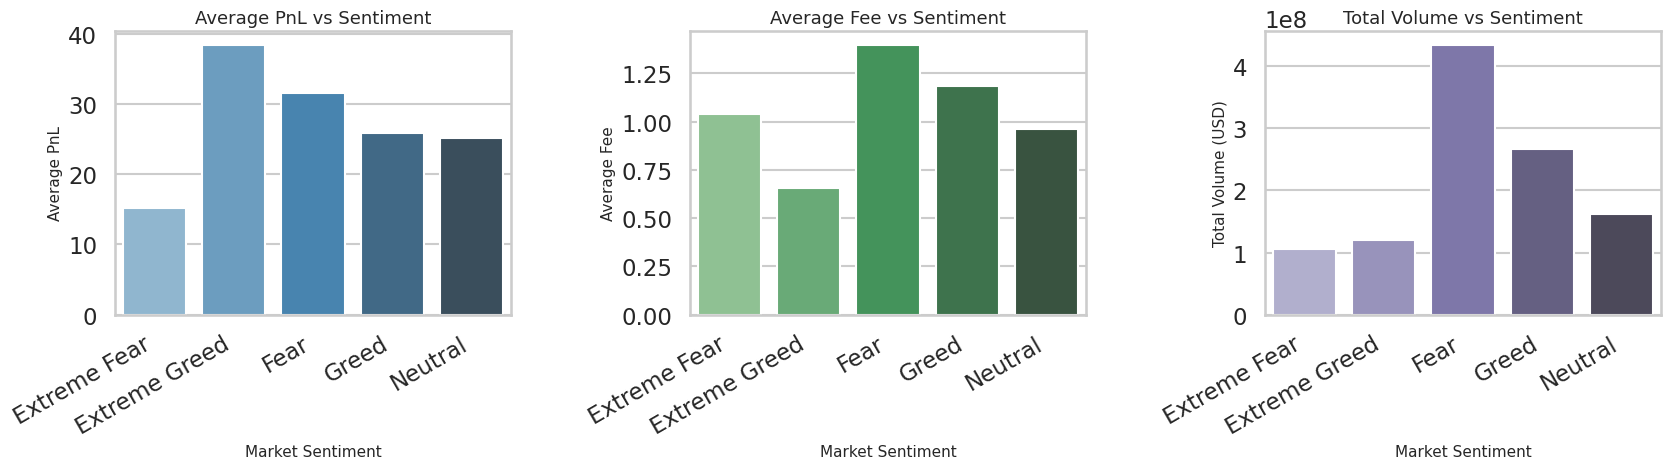

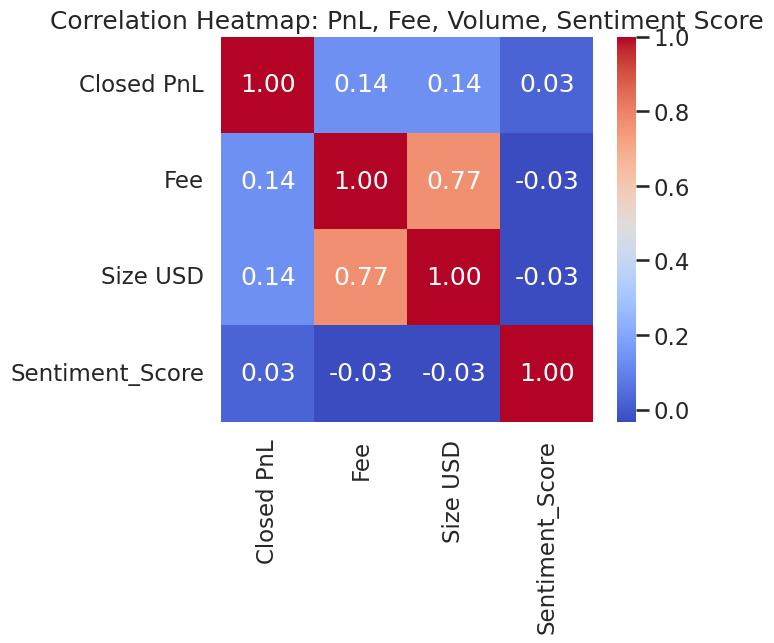

In [64]:
print("=== STARTING MERGE OF MARKET SENTIMENT AND TRADER DATA ===")

sentiment['date'] = pd.to_datetime(sentiment['date'])
trader['Date'] = pd.to_datetime(trader['Date'])

merged_df = pd.merge(trader, sentiment, left_on='Date', right_on='date', how='inner')

print("Merged DataFrame shape:", merged_df.shape)
print("Merged Columns:", merged_df.columns.tolist())

merged_df['Closed PnL'] = pd.to_numeric(merged_df['Closed PnL'], errors='coerce')
merged_df['Fee'] = pd.to_numeric(merged_df['Fee'], errors='coerce')
merged_df['Size USD'] = pd.to_numeric(merged_df['Size USD'], errors='coerce')

agg_df = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'median'],
    'Fee': 'mean',
    'Size USD': 'sum',
    'Trade ID': 'count'
}).reset_index()

agg_df.columns = ['Sentiment', 'Avg_PnL', 'Median_PnL', 'Avg_Fee', 'Total_Volume', 'Trade_Count']

print("\n=== Aggregated Trader Behavior by Market Sentiment ===")
display(agg_df)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Sentiment', y='Avg_PnL', data=agg_df, palette='Blues_d')
plt.title('Average PnL vs Sentiment', fontsize=13)
plt.xlabel('Market Sentiment', fontsize=11)
plt.ylabel('Average PnL', fontsize=11)
plt.xticks(rotation=30, ha='right')

plt.subplot(1, 3, 2)
sns.barplot(x='Sentiment', y='Avg_Fee', data=agg_df, palette='Greens_d')
plt.title('Average Fee vs Sentiment', fontsize=13)
plt.xlabel('Market Sentiment', fontsize=11)
plt.ylabel('Average Fee', fontsize=11)
plt.xticks(rotation=30, ha='right')

plt.subplot(1, 3, 3)
sns.barplot(x='Sentiment', y='Total_Volume', data=agg_df, palette='Purples_d')
plt.title('Total Volume vs Sentiment', fontsize=13)
plt.xlabel('Market Sentiment', fontsize=11)
plt.ylabel('Total Volume (USD)', fontsize=11)
plt.xticks(rotation=30, ha='right')

plt.tight_layout(pad=3.0)
plt.show()


corr_cols = ['Closed PnL', 'Fee', 'Size USD']
if 'value' in merged_df.columns:
    merged_df['Sentiment_Score'] = merged_df['value']
    corr_cols.append('Sentiment_Score')

corr_matrix = merged_df[corr_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: PnL, Fee, Volume, Sentiment Score')
plt.show()


In [65]:
print(merged_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'Date_x', 'timestamp', 'value', 'classification', 'date',
       'Date_y', 'Sentiment_Score'],
      dtype='object')


In [66]:
merged_df['Date_x'] = pd.to_datetime(merged_df['Date_x'], errors='coerce')
merged_df = merged_df.sort_values('Date_x')

merged_df = merged_df.rename(columns={'Date_x': 'Date'})


## 🧠 Step 6 — Advanced Insights: Market–Trader Dynamics
- Prepare and clean merged dataset for advanced analysis  
- Analyze **profit distribution** across different market sentiments (Fear vs Greed)  
- Visualize **trade size vs profit** relationships using scatter plots  
- Compute and plot **7-day rolling averages** for PnL and Fees  
- Detect **anomalies in PnL** using a 2σ (standard deviation) threshold  
- Summarize total records and anomalies detected for insights  


✅ Data ready for advanced insights.



/tmp/ipython-input-372098120.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


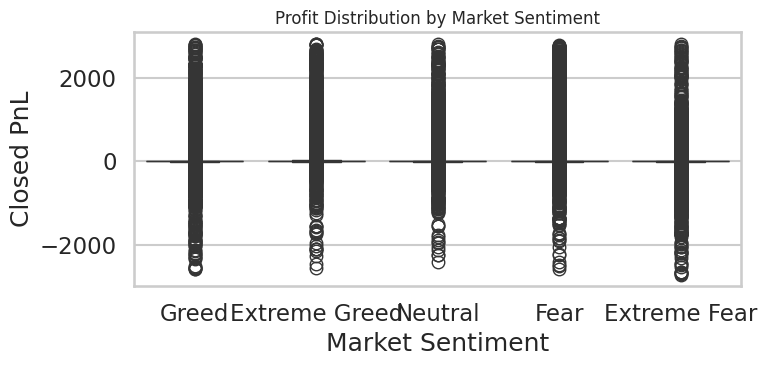

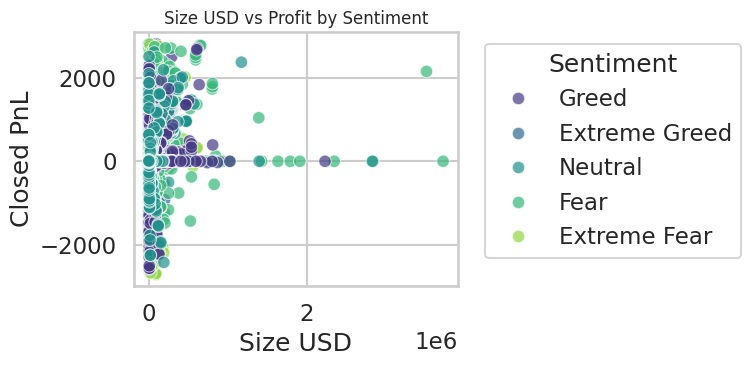

<Figure size 800x400 with 0 Axes>

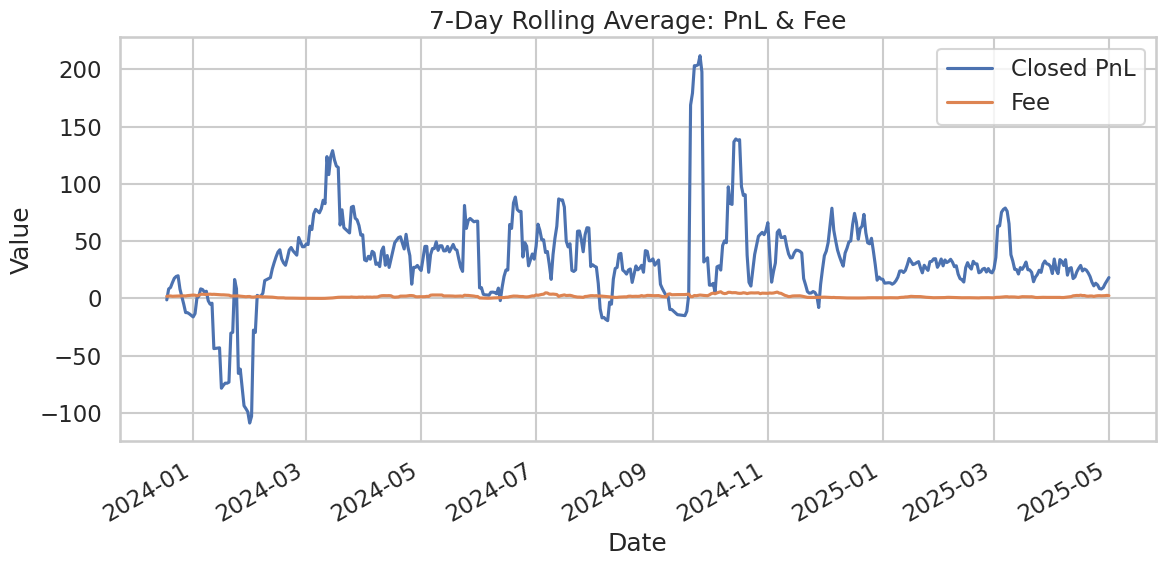

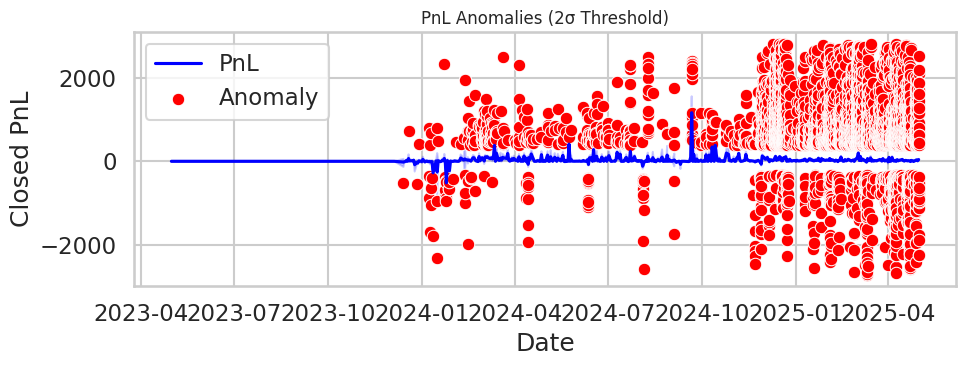

Total Records: 210368
Anomalies Detected: 5580
Advanced Insights successfully generated.


In [67]:
if 'Date_x' in merged_df.columns:
    merged_df['Date_x'] = pd.to_datetime(merged_df['Date_x'], errors='coerce')
    merged_df = merged_df.sort_values('Date_x')
    merged_df = merged_df.rename(columns={'Date_x': 'Date'})
elif 'Date' in merged_df.columns:
    merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
    merged_df = merged_df.sort_values('Date')

if 'classification' not in merged_df.columns:
    print("⚠️ Sentiment column not found. Please check column names.")
else:
    print("✅ Data ready for advanced insights.\n")

plt.figure(figsize=(8, 4))
sns.boxplot(
    data=merged_df,
    x='classification',
    y='Closed PnL',
    palette='viridis'
)
plt.title('Profit Distribution by Market Sentiment', fontsize=12)
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.tight_layout()
plt.show()

x_col = 'Size USD' if 'Size USD' in merged_df.columns else 'Execution Price'

plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=merged_df,
    x=x_col,
    y='Closed PnL',
    hue='classification',
    alpha=0.7,
    palette='viridis'
)
plt.title(f'{x_col} vs Profit by Sentiment', fontsize=12)
plt.xlabel(x_col)
plt.ylabel('Closed PnL')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

roll_df = (
    merged_df.groupby('Date')
    .agg({'Closed PnL': 'mean', 'Fee': 'mean'})
    .rolling(7)
    .mean()
)

plt.figure(figsize=(8, 4))
roll_df.plot(title='7-Day Rolling Average: PnL & Fee', ylabel='Value', xlabel='Date')
plt.tight_layout()
plt.show()

mean_pnl = merged_df['Closed PnL'].mean()
std_pnl = merged_df['Closed PnL'].std()

merged_df['Anomaly'] = np.where(
    abs(merged_df['Closed PnL'] - mean_pnl) > 2 * std_pnl, 1, 0
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=merged_df, x='Date', y='Closed PnL', label='PnL', color='blue')
sns.scatterplot(
    data=merged_df[merged_df['Anomaly'] == 1],
    x='Date',
    y='Closed PnL',
    color='red',
    label='Anomaly'
)
plt.title('PnL Anomalies (2σ Threshold)', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Closed PnL')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total Records: {len(merged_df)}")
print(f"Anomalies Detected: {merged_df['Anomaly'].sum()}")
print("Advanced Insights successfully generated.")
